In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
# import hdf5plugin
# import h5py as h5
import numba

In [2]:
def ttc_to_g2(ttc, time=None):
    """Calculate g2 function from TTC

    Args:
        cor (np.ndarray): sqaure correlation matrix (TTC)
        time (np.ndarray, optional): 1D vector of lag times. Defaults to None.
            If None, np.arange will be used for evenly spaced time bins.
    """

    ntimes = ttc.shape[0]
    if time is None:
        time = np.arange(ntimes) + 1

    # initialize output array
    tau = np.ones(ntimes)
    g2 = np.ones(ntimes)
    g2_err = np.ones(ntimes)
    tau = time
    for i in range(1, ntimes):
        dia = np.diag(ttc, k=i)
        ind = np.where(np.isfinite(dia))
        if len(dia[ind]):
            g2[i-1] = np.mean(dia[ind])
            g2_err[i-1] = np.std(dia[ind])
    g2_err *= np.sqrt(1.0 / (ntimes))
    return tau, g2[:-1], g2_err[:-1]

In [3]:
@numba.njit("float32[:,::1](uint16[:,::1], uint32[::1])", parallel=True, fastmath=True)
def nbgenerateTTC(data, sqnc):
    # sqnc contains the sequence of frame indices (not ordered)
    n = sqnc.max()
    n_pixels = data.shape[1]
    ttc = np.zeros((n, n), dtype=np.float32)
    for i in numba.prange(data.shape[0]):
        for j in range(i, data.shape[0]):
            img_t1 = data[sqnc[i]].astype(np.float32) # astype float because of numba dot limitation
            img_t2 = data[sqnc[j]].astype(np.float32)
            mean_t1 = img_t1.mean()
            mean_t2 = img_t2.mean()
            num = np.dot(img_t1, img_t2.T)
            denom = mean_t1 * mean_t2
            ttc[i, j] = num / denom / n_pixels
            ttc[j, i] = num / denom / n_pixels
    return ttc

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
numba.config.THREADING_LAYER = 'threadsafe'
print("Threading layer chosen: %s" % numba.threading_layer())

Threading layer chosen: omp


In [5]:
from skimage import io

# Grab data
fpath = "data/image_140deg_30fps.tif"
# read the image stack
img = io.imread(fpath, as_gray=True)
# convert into array
imarray = img.reshape(img.shape[0], img.shape[1]*img.shape[2])

mask = np.ones(imarray[0].shape, np.int64)

In [6]:
import xpcs_analysis_py

_tmp_arr = (imarray * 1e3).T
imarray_int = _tmp_arr.astype(np.uint16)
# imarray_int = np.ascontiguousarray(imarray_int)
# imarray_int = np.random.randint(0, 256, size=(10, 10*10)).astype(np.uint16, order='F')
imarray_int.flags, imarray_int.shape

(  C_CONTIGUOUS : False
   F_CONTIGUOUS : True
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False,
 (90000, 915))

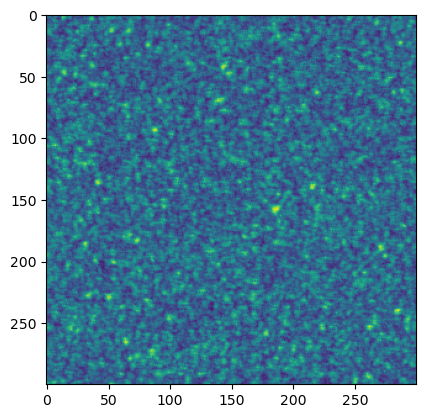

In [7]:
plt.imshow(imarray_int[:,0].reshape(img.shape[1], img.shape[2]))

In [8]:
ttc = xpcs_analysis_py.generateTTC(imarray_int)
ttc.min(), ttc.max()

Npixels: 90000
Nframes: 915


KeyboardInterrupt: 

In [ ]:
# ttc = nbgenerateTTC(imarray_int.T, np.arange(imarray_int.shape[0]).astype(np.uint32))

In [9]:
ttc.min(), ttc.max()

(0.997503745307546, 1.072157416608004)

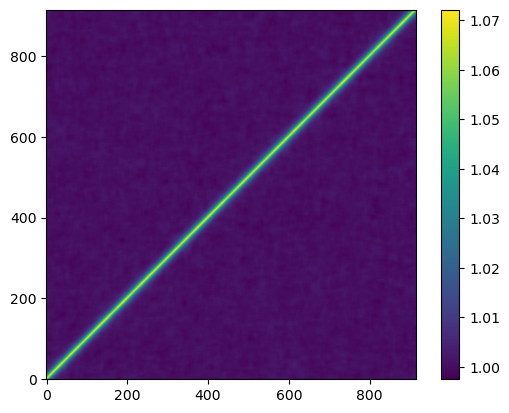

In [10]:
plt.imshow(
    ttc,
    # norm=SymLogNorm(1.5),
    origin='lower',
    cmap='viridis',
    # extent = [time.min(), time.max(), time.min(), time.max()],
)
plt.colorbar()

In [12]:
dt = 1/30
time = np.linspace(dt, ttc.shape[0]*dt, ttc.shape[0])

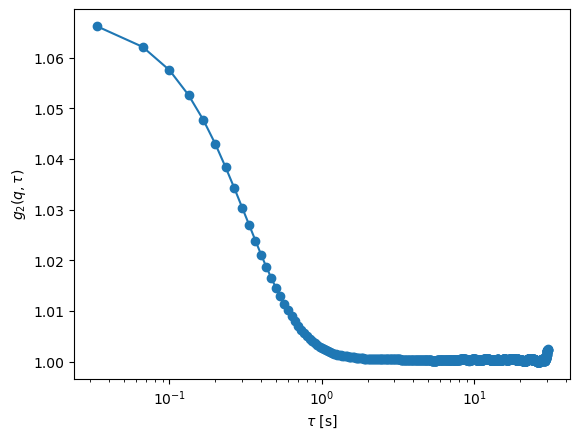

In [14]:
tau, g2, g2_err = ttc_to_g2(ttc)
plt.errorbar(time[:g2.size], g2, yerr=g2_err, marker='o', capsize=3, linestyle='-')
plt.xscale('log')
# plt.xlim(time[0] - 1e-4, 1)
# plt.ylim(0.9, 1)
plt.ylabel(r'$g_2(q, \tau)$')
plt.xlabel(r'$\tau$ [s]')
plt.show()

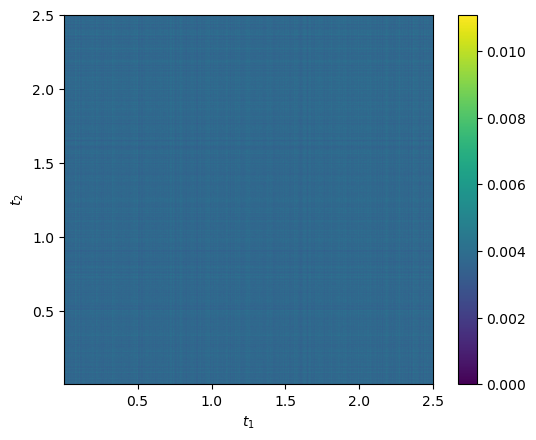

In [15]:
fig, ax = plt.subplots()
ttc = ttc[:4999, :4999]
np.fill_diagonal(ttc, np.mean(ttc))
ttc_plot = ax.imshow(
    ttc,
    # norm=LogNorm(),
    origin='lower',
    cmap='viridis',
    extent = [time.min(), time.max(), time.min(), time.max()],
)
# ax_x = ax.secondary_yaxis('right')
# ax_x.set_yticks(np.arange(0,ttc_submat.shape[0]))
# ax_y = ax.secondary_xaxis('top')
# ax_y.set_xticks(np.arange(0,ttc_submat.shape[0]))
ax.set_xlabel('$t_1$')
ax.set_ylabel('$t_2$')
fig.colorbar(ttc_plot)
plt.show()

In [16]:
time[0] - 1e-4

0.0004

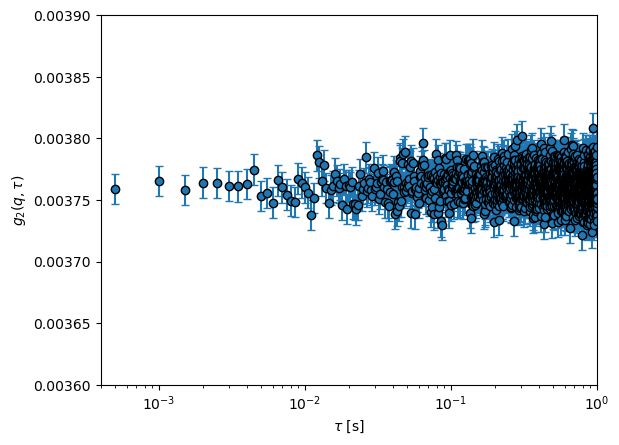

In [17]:
_, g2, g2_err = ttc_to_g2(ttc, 500)
plt.errorbar(time[:g2.size], g2, yerr=g2_err, marker='o', markeredgecolor='k', capsize=3, linestyle='')
plt.xscale('log')
plt.xlim(time[0] - 1e-4, 1)
plt.ylim(0.0036, 0.0039)
plt.ylabel(r'$g_2(q, \tau)$')
plt.xlabel(r'$\tau$ [s]')
plt.show()